In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from datetime import datetime
import re
# Cargar archivos y concatenar ventas
sales_2023=pd.read_excel("SALES_2023.xlsx")
sales_2024=pd.read_excel("SALES_2024.xlsx")
sales_2025=pd.read_excel("SALES_2025.xlsx")
#concatenar
Sales_Total=pd.concat([sales_2023,sales_2024,sales_2025],ignore_index=True)
#cargar target
target_df=pd.read_excel("Targets.xlsx")

In [ ]:
target_df=pd.read_excel("Targets.xlsx",header=4)
target_df.dropna(inplace=True)
target_df.reset_index(drop=True,inplace=True)
# df.columns = ['SalesPerson ID', 'ene-24', 'feb-24', 'mar-24', 'abr-24', 'may-24', 'jun-24', 'jul-24','ago-2024']

In [ ]:
sheets = pd.read_excel('DimensionTables.xlsx',sheet_name=None)  # Tabla de demnesiones
print(sheets.keys())
df_customer=sheets["Customer"]
df_product=sheets["Product"]
df_productgroup=sheets["ProductGroup"]
df_salesperson=sheets["SalesPerson"]

dict_keys(['Customer', 'Product', 'ProductGroup', 'SalesPerson'])


In [ ]:
#limipieza y preparacion de los datos
sales_enriched=Sales_Total.merge(df_customer, on="Customer ID",how='left'
).merge(df_salesperson,on="SalesPerson ID",how="left"
).merge(df_product,on="Product ID",how="left").merge(df_productgroup,on="Group ID",how="left")


In [ ]:
# verificar valoeres nulos
sales_enriched.isnull().sum()
sales_enriched.head()

,Issue Date,Due Date,Invoice Number,Customer ID,SalesPerson ID,Product ID,Qty Itens,Unit Price,Net Weight,Company Name,...,VENDEDOR,Supervisor ID,SUPERVISOR,Manager ID,Manager,Team,Product,Group ID,Group,Category
0,2023-01-01,2023-02-02,1822917,3787277,196,1154,6,3.11,0.30,Ceasarts,...,Gillian Gonzales,30,Sarah-Jayne Pennington,1,Ronnie Daly,Retail,Product 1154,113,Popcorn,Food
1,2023-01-01,2023-02-12,1748367,673368,265,1154,6,3.11,0.30,Hammer Entertainment,...,Shakil Durham,35,Tahmina Vinson,2,Duane Frame,Distributors,Product 1154,113,Popcorn,Food
2,2023-01-01,2023-01-27,1791138,671829,215,1154,6,3.04,1.26,Lion shade,...,Sahil Seymour,30,Sarah-Jayne Pennington,1,Ronnie Daly,Retail,Product 1154,113,Popcorn,Food
3,2023-01-01,2023-01-16,1834054,2851340,125,1527,6,2.80,0.69,Phenomenon Co.,...,Akeel Mcleod,35,Tahmina Vinson,2,Duane Frame,Distributors,Product 1527,113,Popcorn,Food
4,2023-01-01,2023-02-02,1822917,3787277,196,1527,6,3.00,0.69,Ceasarts,...,Gillian Gonzales,30,Sarah-Jayne Pennington,1,Ronnie Daly,Retail,Product 1527,113,Popcorn,Food


In [ ]:
# verificar data types y extraer mes y anio
sales_enriched.dtypes
sales_enriched['Issue Date'] = pd.to_datetime(sales_enriched['Issue Date'])
sales_enriched["year_month"]=sales_enriched["Issue Date"].dt.to_period('M')

In [ ]:
#caculo ventas totales
sales_enriched["Total Sales"]=sales_enriched["Qty Itens"]*sales_enriched["Unit Price"]


In [ ]:
# ventas por region
sales_by_region = sales_enriched.groupby(['Region', 'year_month'])['Total Sales'].sum().reset_index()

In [ ]:
# preparacion para la regresion lineal (ventas mensuales totales)
monthly_sales=sales_enriched.groupby("year_month")["Total Sales"].sum().reset_index()

In [ ]:
import pandas as pd
monthly_sales['year_month'] = monthly_sales['year_month'].astype(str)
# monthly_sales['month_num'] = monthly_sales['year_month'].apply(lambda x: x.n)

In [ ]:
# crear secuencia numerica para el tiemp
monthly_sales["time_index"]=np.arange(len(monthly_sales))

In [ ]:
# regresion lineal para predecir ventas del proximo mes
#preparar datos para entrenamiento
X  =monthly_sales[["time_index"]]
y=monthly_sales["Total Sales"]

In [ ]:
# dividir datos usar todo ya que es una serie temporal
# nota mejor usar train_test_split temporal
model=LinearRegression()
model.fit(X,y)

LinearRegression()

In [ ]:
#predecir proximo mes
next_month_index=monthly_sales["time_index"].max()+1
next_month_prediction=model.predict([[next_month_index]])[0]
last_month = monthly_sales['year_month'].iloc[-1]
print(f"\nÚltimo mes con datos: {last_month}")
print(f"Predicción para el próximo mes: ${next_month_prediction:,.2f}")



Último mes con datos: 2025-03
Predicción para el próximo mes: $507,576.65


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [ ]:
#evaluar el modelo
r_squared = model.score(X, y)
print(f"R-squared del modelo: {r_squared:.2f}")


R-squared del modelo: 0.09


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


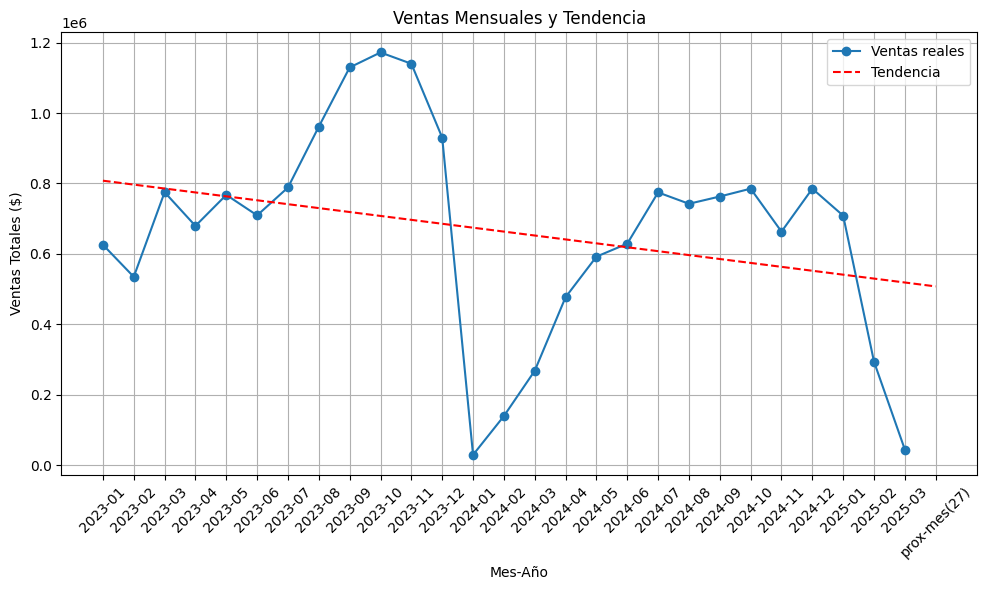

In [ ]:
#vizualizacion
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(monthly_sales["year_month"],monthly_sales["Total Sales"], marker='o', label='Ventas reales')
all_indices = np.append(monthly_sales['time_index'].values, next_month_index)
all_predictions = model.predict(all_indices.reshape(-1, 1))
# Graficar línea de tendencia
all_months = list(monthly_sales['year_month']) + [f"prox-mes({next_month_index})"]
plt.plot(all_months, all_predictions, 'r--', label='Tendencia')
plt.title('Ventas Mensuales y Tendencia')
plt.xlabel('Mes-Año')
plt.ylabel('Ventas Totales ($)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
all_indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

In [ ]:
all_predictions

array([807909.72060847, 796786.27341066, 785662.82621286, 774539.37901506,
       763415.93181726, 752292.48461945, 741169.03742165, 730045.59022385,
       718922.14302605, 707798.69582825, 696675.24863044, 685551.80143264,
       674428.35423484, 663304.90703704, 652181.45983923, 641058.01264143,
       629934.56544363, 618811.11824583, 607687.67104803, 596564.22385022,
       585440.77665242, 574317.32945462, 563193.88225682, 552070.43505902,
       540946.98786121, 529823.54066341, 518700.09346561, 507576.64626781])

In [ ]:
sales_enriched["SalesPerson ID"].unique().order()

array([196, 265, 215, 125, 183, 144, 669, 102, 285, 326, 194, 660])